# Insurance Fraud Claims Detection

In this notebook, I'm going to select the most relevant features along the ones I get from the engineering step

Because I did not spend too much time on feature engineering, I'll try just two methods:

1. L1-based feature selection.
2. Tree-based feature selection. 

Cause it does not require strong assumptions about the distributions of variables

## Libraries and enviroment

In [1]:
# Data Sciences
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

# Plot

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Utils
import os
import pprint

# Set notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.simplefilter(action='ignore')

In [2]:
raw = '../data/raw/insurance_claims.csv'
interim = '../data/interim/'
processed= '../data/processed/'
models= '../models/'

## Data preparation

In [3]:
data = pd.read_csv(processed + 'data_final.csv')

## Feature Selection

### Filter Method: Correlation Matrix

In [4]:
data.shape

(999, 56)

In [5]:
#calculate correlations 
corr_matrix = data.corr()
corr_features = corr_matrix.index

In [6]:
#Correlation with fraud reported
corr_target = abs(corr_matrix['fraud_reported'])
#Filter for relevance
correlated_features = corr_target[corr_target>0.10]
correlated_features

total_claim_amount              0.164781
fraud_reported                  1.000000
policy_annual_premium_groups    0.117394
insured_hobbies_chess           0.294781
insured_hobbies_cross-fit       0.218899
insured_hobbies_others          0.373792
incident_type_Parked Car        0.106760
incident_type_Vehicle Theft     0.121127
collision_type_missing          0.169840
authorities_contacted_None      0.133050
Name: fraud_reported, dtype: float64

**Comment**: Not insightful result

### Embedded Method : L1-based feature selection and Tree-based feature selection

In [7]:
X = pd.read_csv(processed + 'X_final.csv')
y = pd.read_csv(processed + 'y_final.csv')

#### L1-based feature selection

**Fit Model selector**

In [8]:
X.columns

Index(['umbrella_limit', 'capital_gains', 'capital_loss', 'incident_severity', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'total_claim_amount', 'policy_deductable_group', 'policy_annual_premium_groups', 'insured_sex_FEMALE', 'insured_sex_MALE', 'insured_hobbies_chess', 'insured_hobbies_cross-fit', 'insured_hobbies_others', 'incident_type_Multi-vehicle Collision', 'incident_type_Parked Car', 'incident_type_Single Vehicle Collision', 'incident_type_Vehicle Theft', 'collision_type_Front Collision', 'collision_type_Rear Collision', 'collision_type_Side Collision', 'collision_type_missing', 'authorities_contacted_Ambulance', 'authorities_contacted_Fire', 'authorities_contacted_None', 'authorities_contacted_Other', 'authorities_contacted_Police', 'property_damage_NO', 'property_damage_YES', 'property_damage_missing', 'police_report_available_NO', 'police_report_available_YES', 'police_report_available_missing', 'age_groups_15-20',
       'age_g

In [10]:
logit = LogisticRegression(penalty='l1', solver='liblinear', random_state=0)
logit.fit(X, y)
coeffs = pd.Series(logit.coef_[0], index=X.columns)

**Check for Variables importance**

In [20]:
importances = abs(coeffs.sort_values())
#Filter for relevance
important_features = importances[importances>0.5]
important_features

insured_hobbies_others    2.258086
collision_type_missing    0.803447
age_groups_21-25          0.505864
total_claim_amount        0.517884
umbrella_limit            0.574828
insured_hobbies_chess     0.768080
dtype: float64

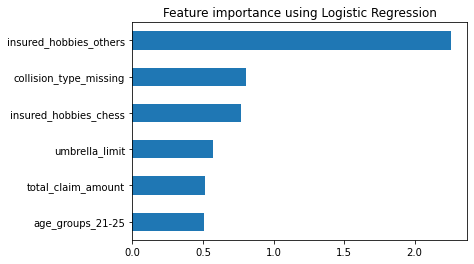

In [21]:
plt.title("Feature importance using Logistic Regression")
important_features.sort_values().plot(kind = "barh")

**Use selector**

In [22]:
selector_one = SelectFromModel(logit, prefit=True)
X_one = selector_one.transform(X)
X_one.shape

(999, 34)

In [23]:
selected_features_one = X.columns[(selector_one.get_support())]

# let's print some stats
print('total features: {}'.format((X.shape[1])))
print('selected features: {}'.format(len(selected_features_one)))
print('\n', selected_features_one.values)

total features: 55
selected features: 34

 ['umbrella_limit' 'incident_severity' 'incident_hour_of_the_day'
 'bodily_injuries' 'witnesses' 'total_claim_amount'
 'policy_deductable_group' 'insured_sex_MALE' 'insured_hobbies_chess'
 'insured_hobbies_cross-fit' 'insured_hobbies_others'
 'incident_type_Single Vehicle Collision' 'incident_type_Vehicle Theft'
 'collision_type_Front Collision' 'collision_type_Rear Collision'
 'collision_type_missing' 'authorities_contacted_Fire'
 'authorities_contacted_None' 'authorities_contacted_Other'
 'property_damage_NO' 'property_damage_missing'
 'police_report_available_NO' 'police_report_available_YES'
 'age_groups_21-25' 'age_groups_31-35' 'age_groups_36-40'
 'age_groups_46-50' 'age_groups_56-60' 'months_as_customer_groups_0-50'
 'months_as_customer_groups_51-100' 'months_as_customer_groups_151-200'
 'months_as_customer_groups_201-250' 'months_as_customer_groups_351-400'
 'months_as_customer_groups_401-450']


#### Tree-based feature selection

In [24]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=250,
                     n_jobs=None, oob_score=False, random_state=0, verbose=0,
                     warm_start=False)

In [25]:
importances = forest.feature_importances_
importances

array([0.01984236, 0.02727308, 0.02734775, 0.02390768, 0.03365078,
       0.01544244, 0.02646808, 0.03071776, 0.03631622, 0.02545373,
       0.1559578 , 0.01498619, 0.0146835 , 0.04095548, 0.02576929,
       0.07327366, 0.01057591, 0.00395305, 0.01150362, 0.00434388,
       0.01325624, 0.01468752, 0.01205541, 0.00993651, 0.01417699,
       0.01450241, 0.00548512, 0.01493634, 0.0140444 , 0.01307524,
       0.01335732, 0.01327701, 0.01617486, 0.01688765, 0.01724797,
       0.00182055, 0.00703084, 0.01001512, 0.01215259, 0.01268679,
       0.01292358, 0.00757679, 0.00554343, 0.00630974, 0.00525412,
       0.00980356, 0.01054691, 0.01255006, 0.01156802, 0.01495573,
       0.01005427, 0.00736634, 0.0060928 , 0.00434812, 0.00587739])

1. feature 10 (0.155958)
2. feature 15 (0.073274)
3. feature 13 (0.040955)
4. feature 8 (0.036316)
5. feature 4 (0.033651)
6. feature 7 (0.030718)
7. feature 2 (0.027348)
8. feature 1 (0.027273)
9. feature 6 (0.026468)
10. feature 14 (0.025769)
11. feature 9 (0.025454)
12. feature 3 (0.023908)
13. feature 0 (0.019842)
14. feature 34 (0.017248)
15. feature 33 (0.016888)
16. feature 32 (0.016175)
17. feature 5 (0.015442)
18. feature 11 (0.014986)
19. feature 49 (0.014956)
20. feature 27 (0.014936)


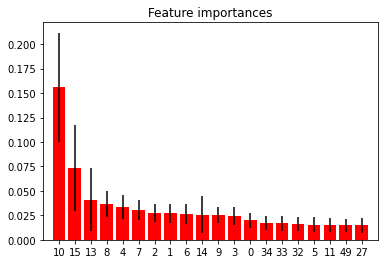

In [26]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances, )[::-1]
n_vars = 20
    
for f in range(n_vars):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the first 10 impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(n_vars), importances[indices][:n_vars],
        color="r", yerr=std[indices][:n_vars], align="center")
plt.xticks(range(n_vars), indices)
plt.xlim([-1, n_vars])
plt.show()

In [27]:
selector_two = SelectFromModel(forest, prefit=True)
X_two = selector_two.transform(X)
X_two.shape

(999, 13)

In [29]:
selected_features_two = X.columns[(selector_two.get_support())]

# let's print some stats
print('total features: {}'.format((X.shape[1])))
print('selected features: {}'.format(len(selected_features_two)))
print('\n', selected_features_two.values)

total features: 55
selected features: 13

 ['umbrella_limit' 'capital_gains' 'capital_loss' 'incident_severity'
 'incident_hour_of_the_day' 'bodily_injuries' 'witnesses'
 'total_claim_amount' 'policy_deductable_group'
 'policy_annual_premium_groups' 'insured_hobbies_chess'
 'insured_hobbies_cross-fit' 'insured_hobbies_others']


#### Methods comparison

In [30]:
features_selected_both = list(set(selected_features_one).intersection(selected_features_two))

In [31]:
features_selected_both

['incident_severity',
 'incident_hour_of_the_day',
 'bodily_injuries',
 'insured_hobbies_others',
 'insured_hobbies_cross-fit',
 'insured_hobbies_chess',
 'total_claim_amount',
 'umbrella_limit',
 'policy_deductable_group',
 'witnesses']

In [32]:
pd.Series(selected_features_two).to_csv(processed + 'selected_features.csv', index=False)

## Final Comment

For simplicity, we prefer to go with features selected with Tree-based feature selection